In [1]:
import devito
import numpy as np

from pylops.utils import dottest
from pylops.waveeqprocessing.twoway import ElasticWave2D
from devito.builtins import initialize_function
from examples.seismic.source import RickerSource, TimeAxis
import matplotlib.pyplot as plt

from examples.seismic import plot_shotrecord

devito.configuration["log-level"] = "ERROR"

## Usefull functions

In [2]:
# function to plot P wave velocity, S wave velocity and density models
def img_model(img1, img2, img3, model, title=""):

    plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0],
                         model.origin[0] + model.domain_size[0],
                         model.origin[1] + model.domain_size[1],
                         model.origin[1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

    scale1 = np.max(img1)
    scale2 = np.min(img1)

    imag1 = ax[0].imshow(np.transpose(img1), vmin=scale1, vmax=scale2,
                         **plt_options_model)
    fig.colorbar(imag1, ax=ax[0])
    ax[0].set_title("Vp (km/s)", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')

    scale3 = np.max(img2)
    scale4 = np.min(img2)

    imag2 = ax[1].imshow(np.transpose(img2), vmin=scale3, vmax=scale4,
                         **plt_options_model)
    fig.colorbar(imag2, ax=ax[1])
    ax[1].set_title("Vs (km/s)", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')

    scale5 = np.max(img3)
    scale6 = np.min(img3)

    imag3 = ax[2].imshow(np.transpose(img3), vmin=scale5, vmax=scale6,
                         **plt_options_model)
    fig.colorbar(imag3, ax=ax[2])
    ax[2].set_title(r"$\rho$ ($g/cm^3$)", fontsize=20)
    ax[2].set_xlabel('z (m)', fontsize=20)
    ax[2].set_ylabel('x (m)', fontsize=20)
    ax[2].set_aspect('auto')

In [3]:
# Function that define source and receiver parameters
def source_rec_term(model, sigma, v0, pos):
    src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range)
    src.coordinates.data[0, :] = pos[0]  # position of source in offset
    src.coordinates.data[0, -1] = pos[1]  # position of source in depth

    # Create symbol for receivers
    rec_vx = Receiver(name='rec_vx', grid=model.grid, npoint=shape[0],
                      time_range=time_range)
    rec_vz = Receiver(name='rec_vz', grid=model.grid, npoint=shape[0],
                      time_range=time_range)
    rec_sigma = Receiver(name='rec_sigma', grid=model.grid, npoint=shape[0],
                         time_range=time_range)

    # Prescribe even spacing for receivers along the x-axis
    rec_vx.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=shape[0])
    rec_vx.coordinates.data[:, 1] = 400.  # postion of receiver at 400 m depth for vx

    rec_vz.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=shape[0])
    rec_vz.coordinates.data[:, 1] = 400.  # postion of receiver at 400 m depth for vz

    rec_sigma.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=shape[0])
    # postion of receiver at 10 m of depth for pressure field
    rec_sigma.coordinates.data[:, 1] = 10.

    src_xx = src.inject(field=sigma[0].forward, expr=src * s)
    src_zz = src.inject(field=sigma[1].forward, expr=src * s)
    src_term = src_xx + src_zz

    rec_term_vx = rec_vx.interpolate(expr=v0[0])
    rec_term_vz = rec_vz.interpolate(expr=v0[1])
    rec_expr = rec_term_vx + rec_term_vz

    expr = sigma[0] + sigma[1]
    rec_term_sigma = rec_sigma.interpolate(expr=expr)
    rec_expr += rec_term_sigma

    return rec_vx, rec_vz, rec_sigma, rec_expr, src_term, src

In [4]:
nx = 200
nz = 120

ndim = 2
shape = (nx, nz) 
spacing = (10., 10.) 
origin = (0., 0.) 
nlayers = 3
domain_size = ((shape[0]-1) * spacing[0], (shape[1]-1) * spacing[1])
nbl = 50
space_order = 8
dtype = np.float32
f0 = 20.0 # 0.020 Khz -> 20.0 Hz
tn = 1800
t0 = 0.
par = "Ip-Is-rho"
src_type = "Ricker"
#dt = 1.492

dswap = True
dswap_disks = 1
dswap_folder = "dswap_ertam_pylops_tests"
dswap_folder_path = "/home/gabriel.sousa/"
dswap_compression = "accuracy"
dswap_compression_value = 1e-6
dswap_verbose = False

## MODEL

In [5]:
# Physical parameters:
vp = np.empty(shape, dtype=dtype)
vs = np.empty(shape, dtype=dtype)
rho = np.empty(shape, dtype=dtype)

# Define a velocity profile. The velocity is in m/s
vp_top = 1500 # 1.5
vp_bottom = 3500 # 3.5
# define a velocity profile in km/s
v = np.empty(shape, dtype=dtype)
v[:] = vp_top  # Top velocity (background)
vp_i = np.linspace(vp_top, vp_bottom, nlayers)
for i in range(1, nlayers):
    v[..., i*int(shape[-1] / nlayers):] = vp_i[i]  # Bottom velocity

vs[:] = 0.5 * v[:]
vs[v < 1510] = 0.0 # 1.51

rho[:] = 0.31*(v[:])**0.25  # Gardner's relation

## GEOMETRY

In [6]:
# Sources
sx = np.linspace(domain_size[0]*.5, domain_size[0]*.5, num=1)
sy = np.linspace(domain_size[0]*.5, domain_size[0]*.5, num=1)
sz = origin[-1] + spacing[-1]

# Receivers
nrecx = shape[0]
rx = np.linspace(origin[0], domain_size[0], nrecx)
rz = origin[-1] + 2 * spacing[-1]

## Operator

In [7]:
Dop = ElasticWave2D(
    shape=shape, 
    origin=origin, 
    spacing=spacing, 
    vp=v, 
    vs=vs, 
    rho=rho, 
    nbl=nbl, 
    space_order=space_order,
    src_x=sx, 
    src_z=sz, 
    rec_x=rx, 
    rec_z=rz, 
    t0=t0, 
    tn=tn, 
    src_type=src_type, 
    f0=f0, 
    dtype=dtype, 
    par=par, 
    #dt=dt,
    dswap=dswap, 
    dswap_disks=dswap_disks, 
    dswap_folder=dswap_folder, 
    dswap_folder_path=dswap_folder_path, 
    dswap_compression=dswap_compression,
    dswap_compression_value=dswap_compression_value,
    dswap_verbose=dswap_verbose,
)

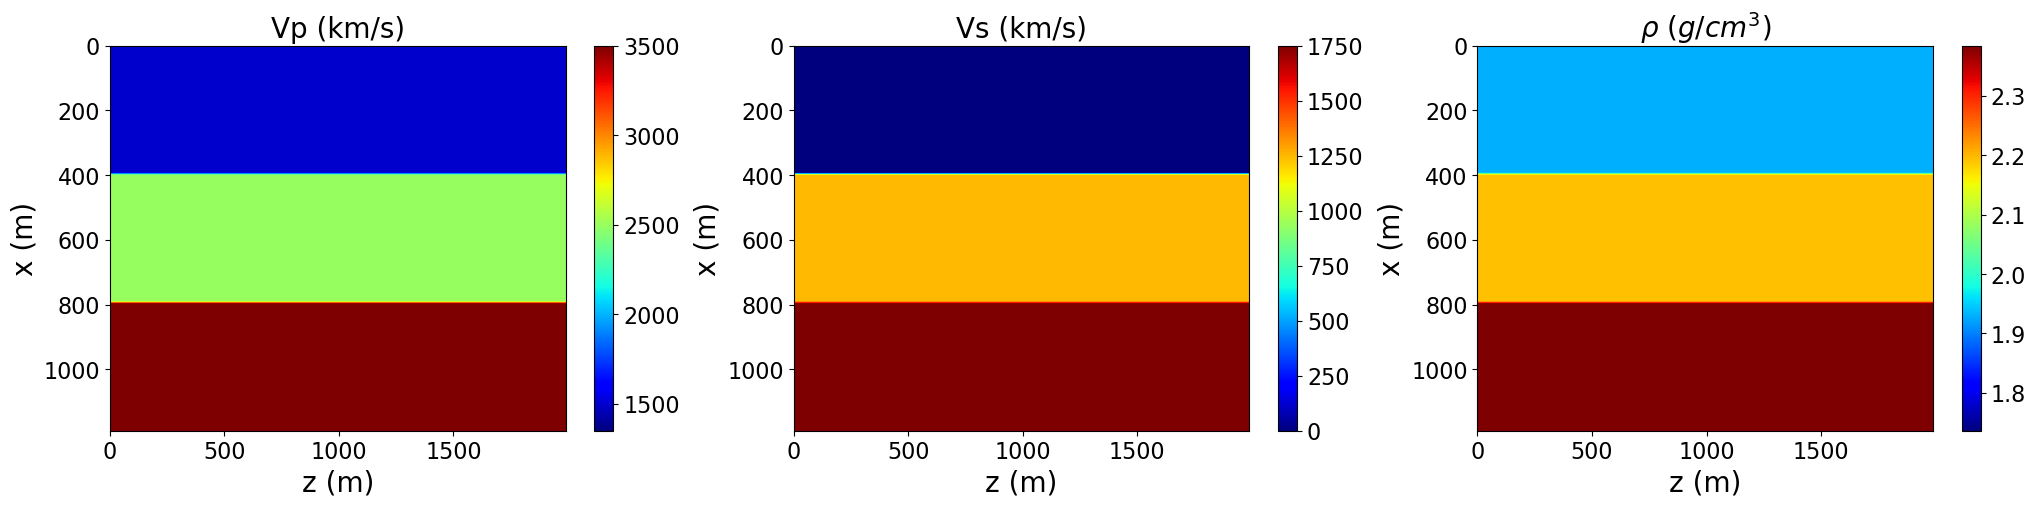

In [8]:
img_model(v, vs, rho, Dop.model)

In [9]:
m = np.array([Dop.model.Ip.data, Dop.model.Is.data, Dop.model.rho.data])

In [10]:
#print(f"Ip >> {np.linalg.norm(Dop.model.Ip.data)}\nIs >> {np.linalg.norm(Dop.model.Is.data)}\nrho >> {np.linalg.norm(Dop.model.rho.data)}")

In [11]:
dobs = Dop*m

rec_tau >> 23.523046493530273
rec_vx >> 3.6326611042022705
rec_vz >> 2.076324462890625
v >> Vector(v_x(t, x + h_x/2, y), v_y(t, x, y + h_y/2))


In [12]:
model = Dop.model

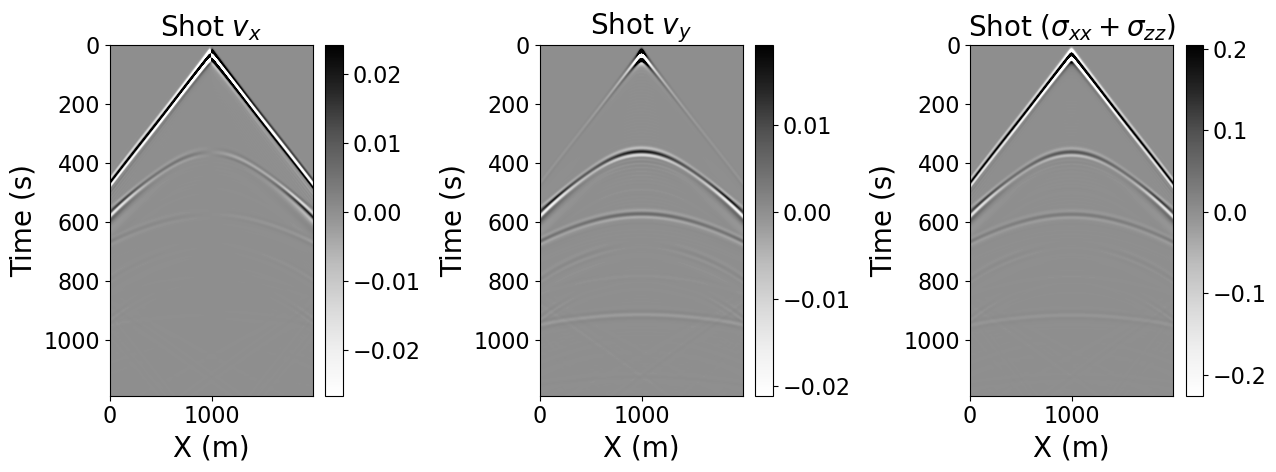

In [13]:
# NBVAL_IGNORE_OUTPUT
slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

aspect_ratio = model.shape[0]/model.shape[1]

plt_options_model = {'cmap': 'Greys', 'extent': [model.origin[0], model.origin[0] +
                                                 model.domain_size[0],
                                                 model.origin[1] +
                                                 model.domain_size[1],
                                                 model.origin[1]]}
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))

scale = np.max(dobs[1][0]) / 10.

img1 = ax[0].imshow(dobs[1][0].T, vmin=scale, vmax=-scale, **plt_options_model)
fig.colorbar(img1, ax=ax[0])
ax[0].set_title(r"Shot $v_x$", fontsize=20)
ax[0].set_xlabel('X (m)', fontsize=20)
ax[0].set_ylabel('Time (s)', fontsize=20)
ax[0].set_aspect('auto')

scale2 = np.max(dobs[2][0]) / 10.
img2 = ax[1].imshow(dobs[2][0].T, vmin=scale2, vmax=-scale2, **plt_options_model)
fig.colorbar(img2, ax=ax[1])
ax[1].set_title("Shot $v_y$", fontsize=20)
ax[1].set_xlabel('X (m)', fontsize=20)
ax[1].set_ylabel('Time (s)', fontsize=20)
ax[1].set_aspect('auto')

scale3 = np.max(dobs[0][0]) / 10.
img3 = ax[2].imshow(dobs[0][0].T, vmin=scale3, vmax=-scale3, **plt_options_model)
fig.colorbar(img3, ax=ax[2])
ax[2].set_title(r"Shot ($\sigma_{xx}+\sigma_{zz}$)", fontsize=20)
ax[2].set_xlabel('X (m)', fontsize=20)
ax[2].set_ylabel('Time (s)', fontsize=20)
ax[2].set_aspect('auto')

plt.tight_layout()